## Problem 1 - Linear Heat Conduction

Solve for the one-dimensional temperature distribution in a square bar of mild steel as given below. The properties of mild steel are:

 - $k$ = 60 [W/m$\cdot$K]
 - $\rho$ = 7800 [kg/m$^3$]
 - $c_p$ = 430 [J/kg$\cdot$K]
 
Assume the convection coefficient is zero on the exposed surfaces, and fixed end temperatures of $T_1$ =100 [$^\circ$C] and $T_2$ = 0 [$^\circ$C].

![SquareBar](Figures/1-SquareBar.png)

This problem deals with heat conduction in a mild steel, square bar. Heat transfers from one end to the other since end temperatures are maintained at 100oC and 0oC. Heat transfer by convection from the exposed surfaces of the bar is considered negligible. This problem is solved for the temperature field in the bar. The expected profile of temperature in the bar is a linear profile connecting the maximum temperature at the 100oC end and the minimum temperature at the 0oC end.  
A domain is created numerically with dimensions of the bar. The energy equation is discretized and implemented on the domain with boundary conditions of the end temperatures. 


## Class Defining a One-Dimensional Cartesian Grid


In finite volume method, it is required to consider a grid on which the equations are discretized for solving any problem. Hence, it is required to define data structure to store the quantities related to grid. These are being used in computational code in addition to calculation of relevant grid parameters. For solving the problem stated above a simple one-dimensional Cartesian grid is taken into consideration.

First to define a grid it is required to introduce class, which includes a method called ``__init__``. It  is commonly known as a *constructor*, as it helps to construct a new object.

The class ``Grid`` takes four arguments, as shown below.

Variable    | Description
:----------:| :------------------------: 
`lx`        | total length of domain in x-direction [m]
`ly`        | total length of domain in y-direction [m]
`lz`        | total length of domain in z-direction [m]
`ncv`       | number of control volumes in domain

[Reference: Taken from the class lecture of Professor DeGroot]

A list of the variables provided by this class is:

Variable    | Description                                         | Array dimension
:----------:| :--------------------------------------------------:|:---------------:
`ncv`       | number of control volumes in domain                 | N/A
`xf`        | array of x locations of face integration points [m] | `ncv+1`
`xP`        | array of x locations of cell centroids [m]          | `ncv+2`
`dx_WP`     | array of distances from W cell to P cell [m]        | `ncv`
`dx_PE`     | array of distances from P cell to E cell [m]        | `ncv`
`Af`        | array of face areas [m$^2$]                         | `ncv+1`
`Aw`        | array of west face areas [m$^2$]                    | `ncv`
`Ae`        | array of east areas [m$^2$]                         | `ncv`
`Ao`        | array of outer surface areas [m$^2$]                | `ncv`
`vol`       | array of cell volumes [m$^3$]                       | `ncv`

[Reference:Taken from the class lecture of Professor DeGroot]


Explanation of Array dimension

`xf   `: generally arrays relating to face-based quantities have dimension `ncv+1` (as this includes the boundary faces)

`Af   `: because of the same reason of previous variable it also has the same dimension i.e., `ncv+1` 

`xP`   : this array has dimension `ncv+2` to account for 'virual cells' located on the boundaries with zero thickness.

Remaining all the variables in the list have dimension equal to `ncv` which is relizable from the basic understanding of grid structure.


In [1364]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

## Class Defining the Set of Coefficients

To solve a linear system which is needed to be solved, it is good to define a class that can store the terms related to the linear system. Hence, in the following, a class is defined for the set of coefficients.

In [1365]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

## Classes Defining the Boundary Conditions

For solving any partial differential equation, boundary conditions are needed. There are generally three types of boundary conditions such as "Dirichlet", "Neumann", and "Robin". For, this problem "Dirichlet" boundary conditions will be required.

### Enumeration Class Defining the Boundary Locations

Now, a special kind of class, called an "enumeration" (abbreviated `Enum` in Python) will be introduced which helps make code more readable.

In [1366]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

**Dirichlet Boundary Condition**

This boundary condition specifies the dependent variable at the boundary, i.e.:

$$ T = T_{b} $$

### Implementation of the Boundary Conditions

While defining classes that deals with applying boundary conditions, having a common interface can make a huge save in effort. In order to take that advantage, each of the member functions (as given below) will be implemented:

- `value()`: gives the calculated boundary value.
- `coeff()`: gives the linearization coefficient for the boundary value, which is equivalent to the derivative of the boundary value with respect to the adjacent cell value
- `apply()`: implements the boundary value to the field variable array that is held as a reference within the class.

In [1367]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

## Class Defining the Diffusion Model

A class called `DiffusionModel` is defined which calculates the fluxes through the east and west faces for each of the control volume. It also calculates the linearization coefficients. These are stored in coefficient arrays and subsequently passed to the `add` method.


In [1368]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

## Function to Solve the Linear System

For solving the linear system that results from discretization process, the coefficients are stored into a sparse matrix storage format.  A linear solver provided through the `scipy` libraries is used to solve that.

In [1369]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

## Solution of the Problem

Following is the code that has been applied to solve this problem.

# Determination of Required Number of Iterations for Convergence

# Convergence Criteria 1e-6

In [1370]:
def problem1(ncv):
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    k = 0.1

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 300

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    return T

In [1371]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= 4*i + 6
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem1(ncv))

Iteration = 0; Max. Resid. = 0.09000000000000002; Avg. Resid. = 0.025000000000000005
Iteration = 1; Max. Resid. = 1.474514954580286e-17; Avg. Resid. = 5.565571152092256e-18
Iteration = 0; Max. Resid. = 0.14999999999999988; Avg. Resid. = 0.024999999999999988
Iteration = 1; Max. Resid. = 2.168404344971009e-17; Avg. Resid. = 1.1449174941446926e-17


# Convergence Criteria 1e-8

In [1372]:
def problem1(ncv):
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    k = 0.1

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 300

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()
    
    # Create list to store the solutions at each iteration
    #T_solns = []
    #Xposition = [np.copy(grid.xP)]
    #Tvalue = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    return T

In [1373]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= 4*i + 6
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem1(ncv))

Iteration = 0; Max. Resid. = 0.09000000000000002; Avg. Resid. = 0.025000000000000005
Iteration = 1; Max. Resid. = 1.474514954580286e-17; Avg. Resid. = 5.565571152092256e-18
Iteration = 0; Max. Resid. = 0.14999999999999988; Avg. Resid. = 0.024999999999999988
Iteration = 1; Max. Resid. = 2.168404344971009e-17; Avg. Resid. = 1.1449174941446926e-17


# Discussion on Determination of Required Number of Iterations for Convergence
Required number of iterations for convergence have been determined. To do this, two convergence criteria were taken into consideration and these are 1e-6, 1e-8. After running the code for the above-mentioned convergence criteria, it was observed that:

### At convergence criteria 1e-6: 
Convergence takes place after 2 iterations (from 0 to 1). And it happened for both number of control volumes (i.e., ncv = 6 & ncv = 10)

### At convergence criteria 1e-8: 
Convergence takes place after 2 iterations (from 0 to 1). And it happened for both number of control volumes (i.e., ncv = 6 & ncv = 10)

### Conclusion: 
As for both consecutive convergence criteria i.e., 1e-6 and 1e-8, 2 iterations (from 0 to 1) were enough for convergence to take place for both 6 and 10 control volumes, so required number of iterations for steel is determined to be 2.

### Explanation:
One of the most vital procedures of an iterative solution’s convergence is measuring the residual. Residual straight away enumerates the error in the solution of the system of equations. In Computational Fluid Dynamics analysis, the residual quantifies the local imbalance of a conserved variable in each control volume. So, each cell in the model will have its individual residual value for each of the equations being solved. 

Exact zero can never be achieved in an iterative numerical solution. However, the lower the residual value is, the more numerically correct the solution.

This residual value which is involved with the quantification of local imbalance of conserved cell, depends upon the source term. If the source term is either zero or a constant or very small, then the local imbalance of conserved cell is also very small hence negligible and as a result convergence takes place with very few number of iterations even 1 or 2.

For this problem, the source term is zero. It is anticipated that, because of this reason, convergence took place very quickly.



# Study of Grid Independence 

In [1374]:
import numpy as np
print(xPosition)
print(Temp)

[array([0.        , 0.00833333, 0.025     , 0.04166667, 0.05833333,
       0.075     , 0.09166667, 0.1       ]), array([0.   , 0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075,
       0.085, 0.095, 0.1  ])]
[array([100.        ,  91.66666667,  75.        ,  58.33333333,
        41.66666667,  25.        ,   8.33333333,   0.        ]), array([100.,  95.,  85.,  75.,  65.,  55.,  45.,  35.,  25.,  15.,   5.,
         0.])]


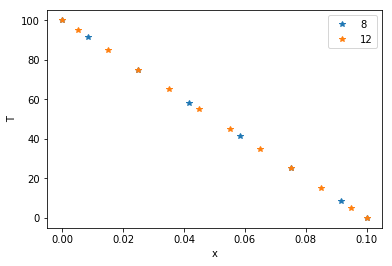

In [1375]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '*', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

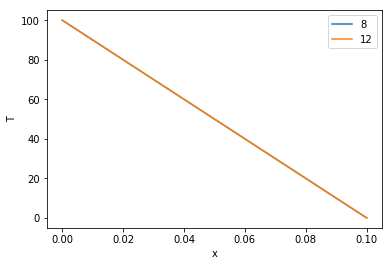

In [1376]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '-', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

# Discussion on the Study of Grid Independence 
Even though above two graphs represent the same result, but they are presented in different ways. From the first graph, it is realizable that it represents the data for both 6 and 10 control volumes. The second graph also represents data for both 6 and 10 control volumes but as they have overlapped each other so it is difficult to differentiate from each other. From this, it can be concluded that 6 control volumes are enough to obtain a grid independent solution

# Discussion on the Results

# Analytical Solution

## Equations Used

In order to better explain the results, analytical solution is presented below:

This problem conduction is taking place only as a means of heat transfer. Theoretically, it is given by the following equation
 
$$\frac{d}{dx}\left(\ K\ \frac{dT}{dx}\ \right)=0$$

, by integrating twice,

$$T=c_1\ x+\ c_2$$

  By solving the equation by the given boundary conditions to get the integration constants: Boundary conditions: 
  
$$T=100 at x=0$$ 
$$T=0 at x=L$$ 

This yields to integration constants of: C2=100, C1=−100xL.

The final analytical solution of the temperature field in the domain is:

$$T=−100 (x / L) +100$$

The analytical solution equation clearly shows a linear behaviour. It confirms the accuracy of the computational result presented above. 

Reference: Bergman, T. L., & Incropera, F. P. (2011). Fundamentals of heat and mass transfer. John Wiley & Sons.  


## List of Values Considered

Variables along with their values are given below


Variable          | Valiue
:----------:      | :------------------------: 
h                 | 0 [W/m$^2\cdot$K]
k                 | 60 [W/m$\cdot$K]
L                 | 0.1 [m]

## Calculation of Analytical Temperature at various x position

In [1377]:
x = [0.  , 0.00833333, 0.025     , 0.04166667, 0.05833333,       0.075     , 0.09166667, 0.1       ]
L = 0.1 

Tatx0 = 100*-1 * (0 / L) +100 
Tatx1 =100*-1 *(0.00833333 / L) +100
Tatx2 =100*-1 *(0.025 / L) +100 
Tatx3 =100*-1 *(0.04166667 / L) +100 
Tatx4 =100*-1 *(0.05833333/ L) +100 
Tatx5 =100*-1 *(0.075/ L) +100 
Tatx6 =100*-1 *(0.09166667/ L) +100 
Tatx7 =100*-1 *(0.1 / L) +100 
print ('Analytical values of T are given below')
print ('---------------------------------------')
print ('T at x = 0 is          ',(Tatx0))
print ('T at x = 0.00833333 is ',(Tatx1))
print ('T at x = 0.025 is      ',(Tatx2))
print ('T at x = 0.04166667 is ',(Tatx3))
print ('T at x = 0.05833333 is ',(Tatx4))
print ('T at x = 0.075 is      ',(Tatx5))
print ('T at x = 0.09166667 is ',(Tatx6))
print ('T at x = 0.1 is        ',(Tatx7))
print ('---------------------------------------')


Analytical values of T are given below
---------------------------------------
T at x = 0 is           100.0
T at x = 0.00833333 is  91.66667
T at x = 0.025 is       75.0
T at x = 0.04166667 is  58.33333
T at x = 0.05833333 is  41.66667
T at x = 0.075 is       25.000000000000014
T at x = 0.09166667 is  8.33332999999999
T at x = 0.1 is         0.0
---------------------------------------


## Comparison between Analytical & Computational Results

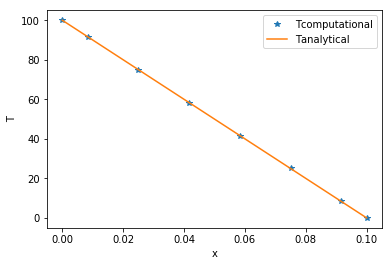

In [1378]:
%matplotlib inline
import matplotlib.pyplot as plt
x =[0.        , 0.00833333, 0.025     , 0.04166667, 0.05833333,       0.075     , 0.09166667, 0.1]
Tcomputational = [100.        ,  91.66666667,  75.        ,  58.33333333,        41.66666667,  25.        ,   8.33333333,   0.]        
Tanalytical    = [100.0,91.66667,75.0,58.33333,41.66667,25.000000000000014,8.33332999999999,0.0]

plt.plot(x, Tcomputational , '*', label='Tcomputational')
plt.plot(x, Tanalytical,'-', label='Tanalytical')
plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

The comparative graph shows that, the compuatational and analytical results are exactly matching with each other. 

So,  from the perspective of accuracy of results, this confirms the accuracy of the computational result.

Again from the perspective of physics, it can be easily concluded that the phenomena which is described in the problem is completely inline with the underlying physics of it.

In the light of theory, it is known that, the term one dimensional means that it is enough to consider one coordinate to describe the spatial variation of the dependent variable. Thus, in case of one dimensional system, temperature variation is noticed in one direction only and heat transfer takes place solely in that direction. Such conditions are called as steady state conditions. Both the analytical and computational result are inline with all the facts described above.